# Linear Statics of 3d Solids

In [1]:
# input data
size = Lx, Ly, Lz = (20, 2, 2)
F = -10  # value of the load at the free end
E = 12000.0  # Young's mpdulus
nu = 0.0  # Poisson's ratio
F * Lx**3 / (3 * E * Ly * Lz**3 / 12)

-1.6666666666666667

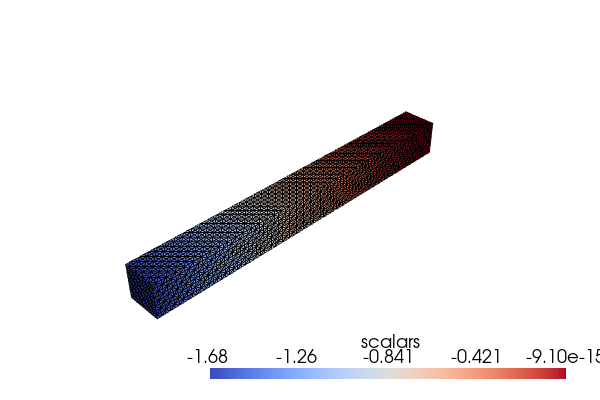

In [2]:
from neumann import repeat
from polymesh.grid import gridH8 as grid
from polymesh.utils.topology import H8_to_H27
from polymesh.space import PointCloud, StandardFrame
from sigmaepsilon import Structure, PointData, SolidMesh
from sigmaepsilon.fem.cells import H8, H27
import numpy as np

# generate grid
gridparams = {"size": size, "shape": (40, 4, 4), "origo": (0, 0, 0), "start": 0}
coords, topo = grid(**gridparams)
# place the origo to the center of the cross section
# at the support
pc = PointCloud(coords)
pc.centralize()
dx = pc.bounds()[0, 0]
pc.move(np.array([-dx, 0.0, 0.0]))
coords = pc.show()
coords, topo = H8_to_H27(coords, topo)
# istoropic material
A = np.array(
    [
        [1, nu, nu, 0, 0, 0],
        [nu, 1, nu, 0, 0, 0],
        [nu, nu, 1, 0, 0, 0],
        [0.0, 0, 0, (1 - nu) / 2, 0, 0],
        [0.0, 0, 0, 0, (1 - nu) / 2, 0],
        [0.0, 0, 0, 0, 0, (1 - nu) / 2],
    ]
) * (E / (1 - nu**2))
# fix points at x==0
cond = coords[:, 0] <= 0.001
ebcinds = np.where(cond)[0]
fixity = np.zeros((coords.shape[0], 3), dtype=bool)
fixity[ebcinds, :] = True
fixity[:, 3:] = True
# unit vertical load at (Lx, 0, 0)
iF = pc.id_of_closest([Lx, 0.0, 0.0])
loads = np.zeros((coords.shape[0], 3))
loads[iF, 2] = F
# pointdata
GlobalFrame = StandardFrame(dim=3)
pd = PointData(coords=coords, frame=GlobalFrame, loads=loads, fixity=fixity)
# celldata
frames = repeat(GlobalFrame.show(), topo.shape[0])
cells = H27(topo=topo, frames=frames)
# set up mesh and structure
mesh = SolidMesh(pd, cells, model=A, frame=GlobalFrame)
structure = Structure(mesh=mesh)
# solve
structure.linear_static_analysis()
dofsol = structure.nodal_dof_solution()
# plot
structure.mesh.pd["scalars"] = dofsol[:, 2]
mesh.pvplot(
    notebook=True,
    window_size=(600, 400),
    cmap="coolwarm",
    jupyter_backend="static",
    scalars="scalars",
)

In [3]:
from neumann import atleast2d
from sigmaepsilon.material.utils import HMH_3d_v

p = atleast2d(H8.lcenter(), front=True)
forces = cells.internal_forces(points=p)
hmh = HMH_3d_v(*[forces[:, i] for i in range(6)])
mesh.config["pyvista", "plot", "show_edges"] = True
# mesh.config['pyvista', 'plot', 'scalars'] = forces[:, 0]
mesh.config["pyvista", "plot", "scalars"] = hmh

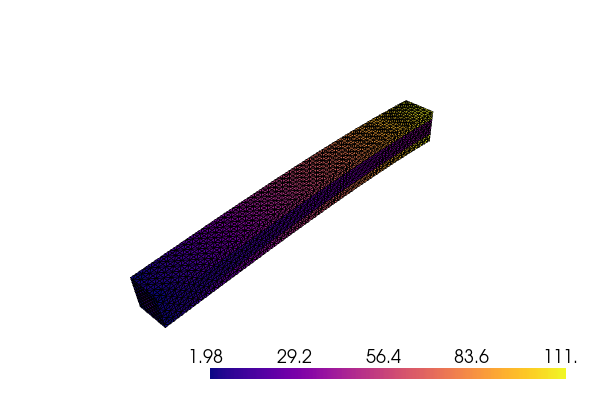

In [4]:
mesh.pd.x = mesh.pd.x + dofsol[:, :3]
cmap = ["blue", "purple", "green", "yellow", "orange", "red"]
cmap = "plasma"
mesh.pvplot(
    notebook=True,
    jupyter_backend="static",
    cmap=cmap,
    window_size=(600, 400),
    config_key=("pyvista", "plot"),
)

In [5]:
import pyvista as pv

pl = pv.Plotter(notebook=False)
pl = mesh.plot(plotter=pl, cmap=cmap, config_key=("pyvista", "plot"))
pl.show()

In [6]:
mesh.cells_at_nodes()

(array([1, 2, 2, ..., 1, 1, 1], dtype=int64),
 array([[  0,   0,   0, ...,   0,   0,   0],
        [  0,   1,   0, ...,   0,   0,   0],
        [  1,   2,   0, ...,   0,   0,   0],
        ...,
        [637,   0,   0, ...,   0,   0,   0],
        [638,   0,   0, ...,   0,   0,   0],
        [639,   0,   0, ...,   0,   0,   0]], dtype=int64),
 array([[ 0,  0,  0, ...,  0,  0,  0],
        [ 4,  0,  0, ...,  0,  0,  0],
        [ 4,  0,  0, ...,  0,  0,  0],
        ...,
        [26,  0,  0, ...,  0,  0,  0],
        [26,  0,  0, ...,  0,  0,  0],
        [26,  0,  0, ...,  0,  0,  0]], dtype=int64))

In [7]:
mesh.nodal_distribution_factors()

array([[1.        , 0.49991598, 0.24995799, ..., 1.        , 0.49843446,
        1.        ],
       [0.50156554, 0.25075352, 0.12537676, ..., 0.50156554, 0.49846971,
        1.        ],
       [0.50153029, 0.25075546, 0.12537773, ..., 0.50153029, 0.49845321,
        1.        ],
       ...,
       [0.12501695, 0.25003637, 0.49999445, ..., 0.49999445, 0.49996682,
        1.        ],
       [0.12500381, 0.24999946, 0.50003318, ..., 0.50003318, 0.5000014 ,
        1.        ],
       [0.12497577, 0.24994307, 0.4999986 , ..., 0.4999986 , 1.        ,
        1.        ]])